<a href="https://colab.research.google.com/github/abhitall/Sketch2Code/blob/main/Sketch2Code_Image_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries

import time, sys, os, random, cv2
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
from shutil import copy

In [ ]:
# grabing dataset from Google Drive
# This only needs to be done once per notebook.

# Installing PyDrive wrapper & importing related libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authentication and creating the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Downloading dataset archive based on its file ID.
download = drive.CreateFile({'id': '1w1wASKEFF72m-h_Fmhh7zolnygd-r0tl'})
download.GetContentFile('sketchs.zip')


    100% |████████████████████████████████| 993kB 16.3MB/s 

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [ ]:
# extracting and cleaning up archive
# This only needs to be done once per notebook.

# extracting archive
!unzip sketchs.zip
# cleaning up archive file
!rm sketchs.zip

Archive:  sketchs.zip
   creating: sketchs/
  inflating: sketchs/class_descriptions.csv  
  inflating: sketchs/dataset.csv     
  inflating: sketchs/dataset.json    
   creating: sketchs/web/
  inflating: sketchs/web/05495118-dcee-4e4e-bee1-b6823096e2b7.png  
  inflating: sketchs/web/094573f5-917f-4350-b8b5-3c828c834b57.png  
  inflating: sketchs/web/0bb2725b-88b4-4734-98f1-3d7d860434e9.html  
  inflating: sketchs/web/0bb2725b-88b4-4734-98f1-3d7d860434e9.png  
  inflating: sketchs/web/0e883baf-e153-4a42-8e0c-f8cde7c179c3.png  
  inflating: sketchs/web/0f5761f9-a85c-4b7f-949a-189ab7cf853e.html  
  inflating: sketchs/web/0f5761f9-a85c-4b7f-949a-189ab7cf853e.png  
  inflating: sketchs/web/125ccd38-5f68-48c0-b060-8fb08dca2eca.png  
  inflating: sketchs/web/12ca11b1-9d0b-475b-96c4-ce30aeb496ec.png  
  inflating: sketchs/web/13b9f109-f532-471a-8f39-f19eef551919.png  
  inflating: sketchs/web/16483b6e-47fe-4e9c-b78c-7f0ba4fef80c.png  
  inflating: sketchs/web/17d8a6bc-7322-40e8-a9b4-65930d9c7

In [ ]:
# annotation_bbox dataframe
annotations_bbox = pd.read_csv('sketchs/dataset.csv')

# printing a random sample of entries
annotations_bbox.sample(10)

,id,width,height,tagId,left,top,region_width,region_height
1556,0bb2725b-88b4-4734-98f1-3d7d860434e9,900,1200,1599c0ca-83c0-4da7-b8c7-2a0a4b069fd2,0.011501,0.130869,0.433164,0.045685
1744,05495118-dcee-4e4e-bee1-b6823096e2b7,1200,900,c266ec15-593b-425f-a6e1-384c4df0a781,0.509972,0.406487,0.462488,0.113924
1357,3da7a00f-f912-41df-b9bd-0d469bad53a4,1200,900,69576625-a3c1-40bb-8947-936491484048,0.150997,0.772310,0.418803,0.159494
257,999aa799-f234-4a6e-9c76-b6e98b031c5e,900,924,d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6,0.721468,0.756587,0.235294,0.074890
1284,12ca11b1-9d0b-475b-96c4-ce30aeb496ec,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.773029,0.572310,0.142450,0.072152
1735,05495118-dcee-4e4e-bee1-b6823096e2b7,1200,900,69576625-a3c1-40bb-8947-936491484048,0.522317,0.876108,0.410256,0.116456
1467,7f288e89-a0fb-4f69-b6e8-458faae5915f,1200,900,fcf1ba33-f9f4-4715-a999-e0d65bb7f09f,0.607787,0.554589,0.141500,0.169620
1831,da54575a-4e89-49aa-af1a-c4d8490ba57b,1200,900,69576625-a3c1-40bb-8947-936491484048,0.615000,0.213102,0.062500,0.084444
1022,80ce0ae6-9f89-429b-b2da-ae1b25e45acb,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.490978,0.579905,0.143400,0.043038
1277,12ca11b1-9d0b-475b-96c4-ce30aeb496ec,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.081671,0.103956,0.097816,0.073418


In [ ]:
# renaming columns for convinience
annotations_bbox.rename(columns={'id': 'ImageID', 'tagId': 'LabelName', 'left': 'XMin', 'top': 'YMin'}, inplace=True)

# printing a random sample of entries
annotations_bbox.sample(10)

,ImageID,width,height,LabelName,XMin,YMin,region_width,region_height
636,8ae99b35-2354-4f8b-ade0-9fd98f09f4fe,900,1248,b9944914-2e80-4b6a-8874-0fe55d073c45,0.230986,0.758198,0.380282,0.079108
182,d985982e-3e78-4dd9-a16e-086f4bed223f,1600,840,d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6,0.060940,0.454278,0.360132,0.189076
886,808d5476-08eb-4b03-8997-6d16d1e2a32b,900,1200,fcf1ba33-f9f4-4715-a999-e0d65bb7f09f,0.099662,0.630538,0.125000,0.111392
435,d20b2bf2-ee77-404f-8de3-9238284d1957,1111,900,fcf1ba33-f9f4-4715-a999-e0d65bb7f09f,0.006579,0.713573,0.200658,0.271805
1328,9f638ca2-de14-47dd-9f81-c697e849c3c5,1200,900,69576625-a3c1-40bb-8947-936491484048,0.600190,0.876108,0.250712,0.117722
1414,26246a48-79ca-41d2-b578-5bd82ed14d05,1200,900,43525578-a7e1-4f18-9c3b-2c60952c1bb5,0.287749,0.157120,0.533713,0.148101
1136,8ded829b-7f25-4cd7-8d40-c1d3100d755d,1200,900,d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6,0.094017,0.597627,0.377968,0.093671
1445,c237d277-27c4-465d-b2d6-e4eca2c069ed,1200,900,43525578-a7e1-4f18-9c3b-2c60952c1bb5,0.276353,0.826741,0.311491,0.131646
42,13b9f109-f532-471a-8f39-f19eef551919,1600,270,d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6,0.619310,0.548384,0.165198,0.385621
764,3c0e378f-434b-451b-a88a-99fac1e8d4ee,783,1600,43525578-a7e1-4f18-9c3b-2c60952c1bb5,0.093264,0.382437,0.784974,0.135443


In [ ]:
# adding other required columns based on the information in annotations_bbox dataframe
annotations_bbox['XMax'] = annotations_bbox['XMin'] + annotations_bbox['region_width']
annotations_bbox['YMax'] = annotations_bbox['YMin'] + annotations_bbox['region_height']

#printing a random sample of entries
annotations_bbox.sample(10)

,ImageID,width,height,LabelName,XMin,YMin,region_width,region_height,XMax,YMax
1146,bc18ff8e-a345-40ed-9f3e-ccaf0ca2141f,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.801519,0.226741,0.122507,0.074684,0.924027,0.301424
1948,bd73cef8-a70e-483e-b0f5-81a7a81ca95d,1200,900,b9944914-2e80-4b6a-8874-0fe55d073c45,0.477500,0.378657,0.162500,0.068889,0.640000,0.447546
918,87fb3dd7-8551-41f3-bcb1-da87ddeccf6e,900,1200,43525578-a7e1-4f18-9c3b-2c60952c1bb5,0.398649,0.572310,0.395270,0.139240,0.793919,0.711551
802,fa3aae44-9496-4557-a085-d1407b5b3e8e,900,1200,b9944914-2e80-4b6a-8874-0fe55d073c45,0.728040,0.716614,0.133446,0.032911,0.861486,0.749525
1364,6475faaf-d427-4a61-a28d-aa781d5bdc91,1200,900,c266ec15-593b-425f-a6e1-384c4df0a781,0.023742,0.250791,0.433998,0.112658,0.457740,0.363449
439,e4da414a-0ad2-4580-ab2e-039a06532ea9,900,1091,b9944914-2e80-4b6a-8874-0fe55d073c45,0.051724,0.711545,0.157635,0.054767,0.209360,0.766312
5,2469da39-65f0-428b-a1de-cedbba7db32e,1600,564,530d20f2-7260-42f1-bd42-bddca465c9e9,0.747063,0.149696,0.113436,0.137500,0.860499,0.287196
415,8c7ccc76-83a9-4dde-8be3-84895b387230,900,1116,a04aa534-942d-4640-af99-39851705e59b,0.025189,0.833249,0.287154,0.073022,0.312343,0.906271
783,bdd7286c-6da8-4caa-a7a0-ffcaa7e0ba02,783,1600,b9944914-2e80-4b6a-8874-0fe55d073c45,0.274611,0.233070,0.354922,0.082278,0.629534,0.315348
1727,b5e97de6-94ce-49e9-8553-ca8a8653f35d,1200,900,a04aa534-942d-4640-af99-39851705e59b,0.258310,0.631804,0.178538,0.074684,0.436847,0.706487


In [ ]:
# creating a dataframe for class descriptions
class_descriptions = pd.read_csv('sketchs/class_descriptions.csv')

#printing all entries
class_descriptions.head(10)

,name,class
0,d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6,CheckBox
1,69576625-a3c1-40bb-8947-936491484048,Button
2,b9944914-2e80-4b6a-8874-0fe55d073c45,Label
3,530d20f2-7260-42f1-bd42-bddca465c9e9,RadioButton
4,c266ec15-593b-425f-a6e1-384c4df0a781,TextBox
5,1599c0ca-83c0-4da7-b8c7-2a0a4b069fd2,Heading
6,a04aa534-942d-4640-af99-39851705e59b,ComboBox
7,66565887-d482-4579-ae34-d0ca1869f3d7,Link
8,fcf1ba33-f9f4-4715-a999-e0d65bb7f09f,Image
9,43525578-a7e1-4f18-9c3b-2c60952c1bb5,Paragraph


In [ ]:
# dataframe for storing image and its uri
images_boxable = pd.DataFrame({'image_name':annotations_bbox['ImageID'].unique() + '.png'})
images_boxable['image_uri'] = images_boxable.apply(lambda x: 'sketchs/web/' + x['image_name'], axis='columns')

# saving images_boxable as csv file
images_boxable.to_csv('sketchs/images_boxable_name.csv', index = False)

# printing a sample of images_boxable dataframe
images_boxable.sample(10)

,image_name,image_uri
2,6209fb2c-ec39-4f8e-b86b-075cc181a81c.png,sketchs/web/6209fb2c-ec39-4f8e-b86b-075cc181a8...
50,98e674be-e53f-4fad-880d-a97eca09d16f.png,sketchs/web/98e674be-e53f-4fad-880d-a97eca09d1...
75,808d5476-08eb-4b03-8997-6d16d1e2a32b.png,sketchs/web/808d5476-08eb-4b03-8997-6d16d1e2a3...
125,30f5f8e2-47c5-4977-933c-e005cc275663.png,sketchs/web/30f5f8e2-47c5-4977-933c-e005cc2756...
11,9e699db6-adf6-42ea-a833-1a4e5633f029.png,sketchs/web/9e699db6-adf6-42ea-a833-1a4e5633f0...
18,d985982e-3e78-4dd9-a16e-086f4bed223f.png,sketchs/web/d985982e-3e78-4dd9-a16e-086f4bed22...
138,db6d137e-42f1-494a-8a13-69532d740209.png,sketchs/web/db6d137e-42f1-494a-8a13-69532d7402...
26,6ab50c05-57cd-4e86-a601-c1524c509475.png,sketchs/web/6ab50c05-57cd-4e86-a601-c1524c5094...
36,3892666c-c7c7-4b69-9000-9f050d2ca7fb.png,sketchs/web/3892666c-c7c7-4b69-9000-9f050d2ca7...
24,1b080c62-85d1-4222-9601-c4eec8b2cff8.png,sketchs/web/1b080c62-85d1-4222-9601-c4eec8b2cf...


In [ ]:
# total number of images 
print('length of the images_boxable: %d' %(len(images_boxable)))

#printing a sample
img_name = images_boxable['image_name'][random.randint(1,len(images_boxable))]
img_uri = images_boxable['image_uri'][random.randint(1,len(images_boxable))]
print('\t image_name: %s' % (img_name))
print('\t img_uri: %s' % (img_uri))
print('')

# total number of bounding boxes
print('length of the annotations_bbox: %d' %(len(annotations_bbox)))
print('The number of bounding boxes are larger than number of images.')
print('')

# total number of classes
print('length of the class_descriptions: %d' % (len(class_descriptions)))

length of the images_boxable: 149
	 image_name: 8d7dfde9-323b-42b8-ae30-8665233cc870.png
	 img_uri: sketchs/web/9e4b1496-e1cf-4bcc-9171-34e1fbbef25f.png

length of the annotations_bbox: 2001
The number of bounding boxes are larger than number of images.

length of the class_descriptions: 10


(900, 1200, 3)


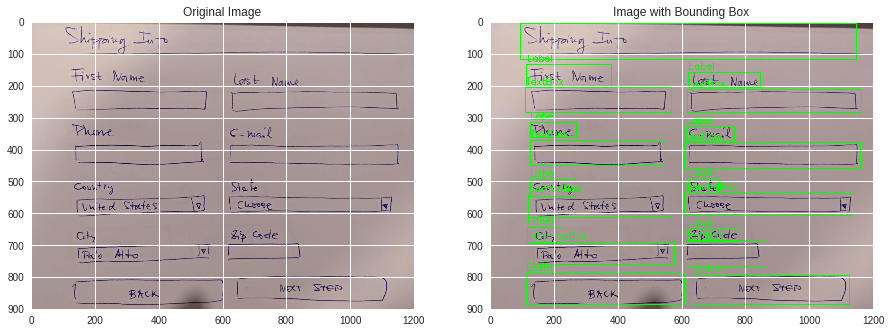

(900, 1200, 3)


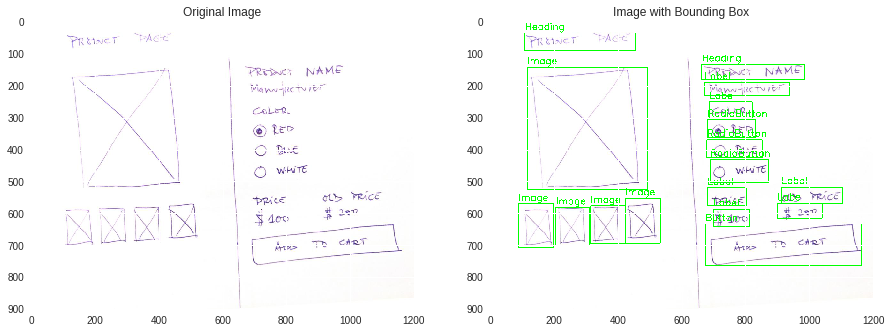

(900, 1200, 3)


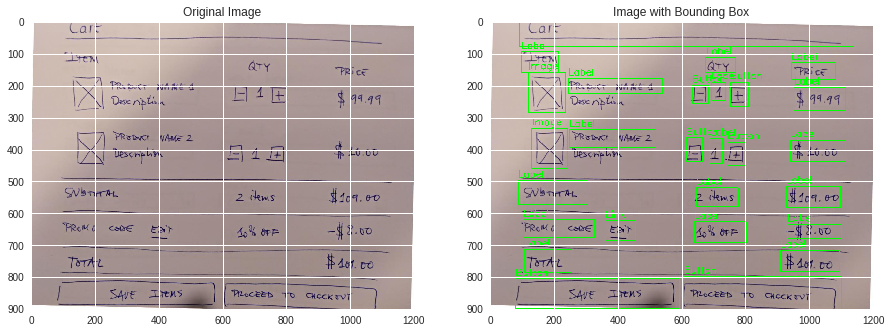

(900, 1200, 3)


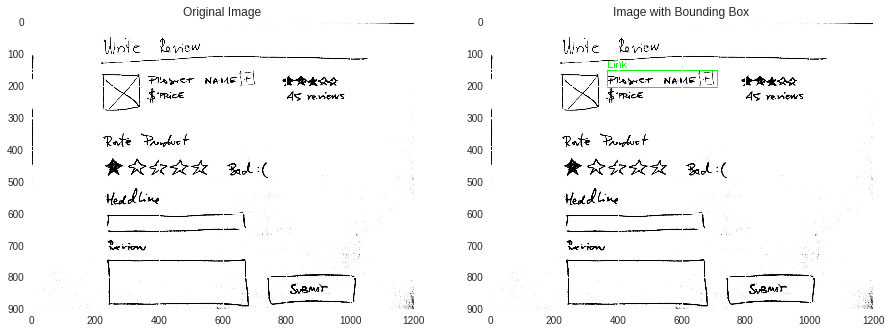

(900, 1200, 3)


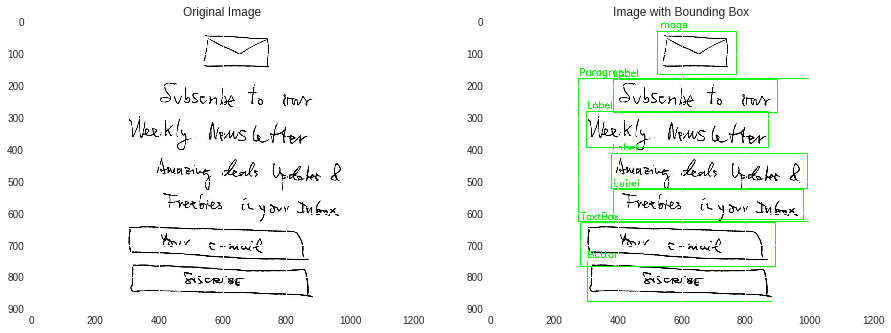

(900, 1200, 3)


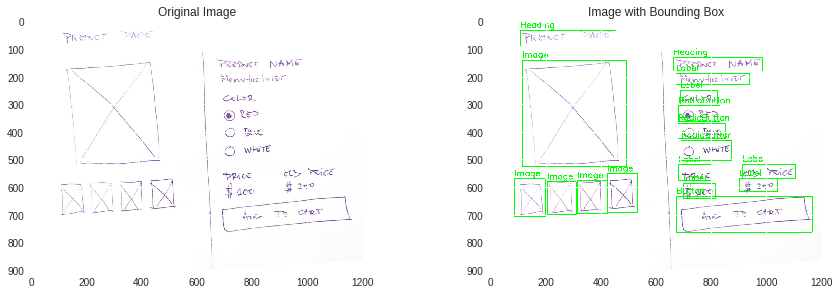

In [ ]:
# data visualization on a random sample of images

for i in range(6):
  # random selection of image
  image_uri = images_boxable['image_uri'][random.randint(0,len(images_boxable)-1)]
  img = io.imread(image_uri)
  height, width, _ = img.shape
  print(img.shape)
  
  # original image plot
  plt.figure(figsize=(48,32))
  plt.subplot(i+1,6,1)
  plt.title('Original Image')
  plt.imshow(img)
  
  # adding bounding bounding boxes to iamges
  img_id = image_uri[12:].replace('.png','')
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  img_bbox = img.copy()
  for index, row in bboxs.iterrows():
      row.head()
      xmin = int(row['XMin']*width)
      xmax = int(row['XMax']*width)
      ymin = int(row['YMin']*height)
      ymax = int(row['YMax']*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions['name']==label_name]
      class_name = class_series['class'].values[0]
      cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img_bbox,class_name,(xmin,ymin-10), font, 1,(0,255,0),2)
      
  # image with bounding box plot    
  plt.subplot(i+1,6,2)
  plt.title('Image with Bounding Box')
  plt.imshow(img_bbox)
  plt.show()

In [ ]:
# directory for dataset path
base_path = 'sketchs/Dataset'

# creating a directory
!mkdir sketchs/Dataset

In [ ]:
# label_name for all classes
for cls in class_descriptions['class']:
  print(class_descriptions[class_descriptions['class']==cls])

                                   name     class
0  d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6  CheckBox
                                   name   class
1  69576625-a3c1-40bb-8947-936491484048  Button
                                   name  class
2  b9944914-2e80-4b6a-8874-0fe55d073c45  Label
                                   name        class
3  530d20f2-7260-42f1-bd42-bddca465c9e9  RadioButton
                                   name    class
4  c266ec15-593b-425f-a6e1-384c4df0a781  TextBox
                                   name    class
5  1599c0ca-83c0-4da7-b8c7-2a0a4b069fd2  Heading
                                   name     class
6  a04aa534-942d-4640-af99-39851705e59b  ComboBox
                                   name class
7  66565887-d482-4579-ae34-d0ca1869f3d7  Link
                                   name  class
8  fcf1ba33-f9f4-4715-a999-e0d65bb7f09f  Image
                                   name      class
9  43525578-a7e1-4f18-9c3b-2c60952c1bb5  Paragraph


In [ ]:
#length of all classes in dataset
for cls in class_descriptions['class']:
  print('There are {} {} in the dataset'.format(len(annotations_bbox[annotations_bbox['LabelName']==class_descriptions[class_descriptions['class']==cls]['name'].values[0]]), cls))

There are 203 CheckBox in the dataset
There are 178 Button in the dataset
There are 756 Label in the dataset
There are 112 RadioButton in the dataset
There are 171 TextBox in the dataset
There are 212 Heading in the dataset
There are 58 ComboBox in the dataset
There are 43 Link in the dataset
There are 155 Image in the dataset
There are 113 Paragraph in the dataset


In [ ]:
#number of images per class in dataset
for cls in class_descriptions['class']:
  print('There are {} images which contain {} '.format(annotations_bbox[annotations_bbox['LabelName']==class_descriptions[class_descriptions['class']==cls]['name'].values[0]]['ImageID'].nunique(), cls))

There are 51 images which contain CheckBox 
There are 89 images which contain Button 
There are 132 images which contain Label 
There are 34 images which contain RadioButton 
There are 71 images which contain TextBox 
There are 109 images which contain Heading 
There are 28 images which contain ComboBox 
There are 25 images which contain Link 
There are 59 images which contain Image 
There are 41 images which contain Paragraph 


In [ ]:
# shuffle the ids of dataframe
def shuffle(df):
    index = list(df.index)
    random.seed(random.randint(0,99))
    random.shuffle(index)
    df = df.loc[index]
    df.reset_index()
    return df

In [ ]:
# supress warnings for chained assignments
pd.options.mode.chained_assignment = None
  
# sub classing of all classes in dataset
for cls in class_descriptions['class']:
  # extracting rows which contain  given class
  df = annotations_bbox[annotations_bbox['LabelName']==class_descriptions[class_descriptions['class']==cls]['name'].values[0]]
  
  # adding required rows
  df['image_name'] = df.apply(lambda x: x['ImageID'] + '.png', axis='columns')
  df['image_uri'] = df.apply(lambda x: 'sketchs/web/' + x['image_name'], axis='columns')
  
  # shuffling rows of dataframe
  df = shuffle(df)
  
  # copying csv to their respective directory
  directory = base_path+'/'+cls
  csv_file = cls.lower()+'_img_uri.csv'
  if not os.path.exists(directory):
    os.makedirs(directory)
  df.to_csv(os.path.join(directory, csv_file), index = False)
  
  # printing sample of dataframe
  print(pd.read_csv(os.path.join(directory, csv_file)).head(1))

                                ImageID  width  height  \
0  d985982e-3e78-4dd9-a16e-086f4bed223f   1600     840   

                              LabelName      XMin      YMin  region_width  \
0  d5cedd3f-acf2-4dce-8ead-e1a74e7e11d6  0.065345  0.252597      0.359031   

   region_height      XMax      YMax  \
0       0.172269  0.424376  0.424866   

                                 image_name  \
0  d985982e-3e78-4dd9-a16e-086f4bed223f.png   

                                           image_uri  
0  sketchs/web/d985982e-3e78-4dd9-a16e-086f4bed22...  
                                ImageID  width  height  \
0  2451e8de-9c13-40ab-ba9d-3141d9d2fdec   1200     900   

                              LabelName      XMin      YMin  region_width  \
0  69576625-a3c1-40bb-8947-936491484048  0.062678  0.897627      0.433998   

   region_height      XMax  YMax                                image_name  \
0       0.102373  0.496676   1.0  2451e8de-9c13-40ab-ba9d-3141d9d2fdec.png   

             

In [ ]:
# additional required variables

# list of all classes
classes = []
# list of directories asscoiated to different classes
saved_dirs = []
# 2d list of urls for each class
uris = []

for cls in class_descriptions['class']:
  classes.append(cls)
  directory = base_path+'/'+cls
  csv_file = cls.lower()+'_img_uri.csv'
  saved_dirs.append(directory)
  uris.append(pd.read_csv(os.path.join(directory, csv_file), usecols = ['image_uri']).values.flatten().tolist())
  
# printing a sample of each list
print(classes)
print(saved_dirs)
print(uris[0])

['CheckBox', 'Button', 'Label', 'RadioButton', 'TextBox', 'Heading', 'ComboBox', 'Link', 'Image', 'Paragraph']
['sketchs/Dataset/CheckBox', 'sketchs/Dataset/Button', 'sketchs/Dataset/Label', 'sketchs/Dataset/RadioButton', 'sketchs/Dataset/TextBox', 'sketchs/Dataset/Heading', 'sketchs/Dataset/ComboBox', 'sketchs/Dataset/Link', 'sketchs/Dataset/Image', 'sketchs/Dataset/Paragraph']
['sketchs/web/d985982e-3e78-4dd9-a16e-086f4bed223f.png', 'sketchs/web/4e16d9d6-be4b-46f5-99e1-8d144b11ecde.png', 'sketchs/web/7f7bf1e5-2f17-4316-ac56-448d99afb35f.png', 'sketchs/web/c6d6c834-f44b-4227-aec1-5bf40f05b0c7.png', 'sketchs/web/dfca0ee0-9e19-49ed-b25c-149a9a713335.png', 'sketchs/web/95e8e4eb-51ba-4193-8d2e-10ccda0547a7.png', 'sketchs/web/6475faaf-d427-4a61-a28d-aa781d5bdc91.png', 'sketchs/web/1f6dce1a-bbe1-4fff-971a-79ebeaa99c1a.png', 'sketchs/web/6ab50c05-57cd-4e86-a601-c1524c509475.png', 'sketchs/web/4ffebf6a-a75b-4361-81f8-95b08fee802b.png', 'sketchs/web/9e699db6-adf6-42ea-a833-1a4e5633f029.png', '

In [ ]:
# saving images to their respective folders
for i in range(len(classes)):
    saved_dir = saved_dirs[i]
    for uri in uris[i]:
        copy(uri, saved_dir)

In [ ]:
# Save images to test and test directory

# uris of training and testing folders
try:
  train_path = base_path+'/'+'train'
  os.makedirs(train_path)
  test_path = base_path+'/'+'test'
  os.makedirs(test_path)
except FileExistsError :
  print('')

# list of all images present in dataset directory
all_imgs = os.listdir('sketchs/web')
all_imgs = [f for f in all_imgs if not f.startswith('.')]
all_imgs = [f for f in all_imgs if not f.endswith('.html')]

# shuffling image list
random.seed(random.randint(0,99))
random.shuffle(all_imgs)

# splitting data in 80:20 ratio for training and testing sets
train_imgs = all_imgs[:int(len(all_imgs)*0.8)]
test_imgs = all_imgs[int(len(all_imgs)*0.8):]
    
# copy images to train directory
for j in range(len(train_imgs)):
    original_path = os.path.join('sketchs/web', train_imgs[j])
    new_path = os.path.join(train_path, train_imgs[j])
    copy(original_path, new_path)
    
# copy images to test directory
for j in range(len(test_imgs)):
    original_path = os.path.join('sketchs/web', test_imgs[j])
    new_path = os.path.join(test_path, test_imgs[j])
    copy(original_path, new_path)

In [ ]:
# number of images in each set
print('number of training images: ', len(os.listdir(train_path)))
print('number of test images: ', len(os.listdir(test_path)))

number of training images:  119
number of test images:  30


In [ ]:
# saving rows associated to training images as a txt file seperated

# list of all images id present in train directory
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]
train_imgs = [name for name in train_imgs if not name.endswith('.html')]
train_imgs_ids = list(map(lambda x: x[:-4], train_imgs))

# various dataframe operations for extracting required data format
train_df= annotations_bbox[annotations_bbox.ImageID.isin(train_imgs_ids)]
train_df['XMin'] = train_df.apply(lambda x: x['XMin'] * x['width'], axis='columns')
train_df['XMax'] = train_df.apply(lambda x: x['XMax'] * x['width'], axis='columns')
train_df['YMin'] = train_df.apply(lambda x: x['YMin'] * x['height'], axis='columns')
train_df['YMax'] = train_df.apply(lambda x: x['YMax'] * x['height'], axis='columns')
train_df['FileName'] = train_df.apply(lambda x: x['ImageID'] + '.png', axis='columns')
train_df = train_df.join(class_descriptions.set_index('name'), on='LabelName')
train_df.rename(columns={'class': 'ClassName'}, inplace=True)
train_df = train_df[['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName']]

# shuffling dataframe rows and storing as a txt file
train_df = shuffle(train_df)
train_df.to_csv(base_path + '/train/' + 'train_annotation.txt' , index = False)

# printing sample of dataframe
print('Parse train_imgs ' + str(len(train_imgs_ids)) + '; Number of boxes: ' + str(len(train_df)))
train_df.head(5)

Parse train_imgs 120; Number of boxes: 1616


,FileName,XMin,XMax,YMin,YMax,ClassName
1484,1f9e8765-44db-4303-b12a-d6b30c9cc5f9.png,63.817665,454.700865,208.623420,270.142407,Label
342,f9c92b4a-b209-4ed6-b172-88c2ffb86a48.png,146.078405,287.254876,212.132357,268.014710,RadioButton
931,1b1f4c8c-92a7-4000-8f07-471d6f8016b1.png,203.988612,678.062689,106.091773,226.851260,ComboBox
1198,2451e8de-9c13-40ab-ba9d-3141d9d2fdec.png,260.968655,421.652412,380.648723,451.281632,Label
1103,d8f269e4-8ecb-4b5b-86ea-4839fb1a6e18.png,133.333334,574.358984,692.800650,772.547485,ComboBox


In [ ]:
# saving rows associated to testing images as a txt file seperated

# list of all images id present in test directory
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]
test_imgs = [name for name in test_imgs if not name.endswith('.html')]
test_imgs_ids = list(map(lambda x: x[:-4], test_imgs))

# various dataframe operations for extracting required data format
test_df= annotations_bbox[annotations_bbox.ImageID.isin(test_imgs_ids)]
test_df['XMin'] = test_df.apply(lambda x: x['XMin'] * x['width'], axis='columns')
test_df['XMax'] = test_df.apply(lambda x: x['XMax'] * x['width'], axis='columns')
test_df['YMin'] = test_df.apply(lambda x: x['YMin'] * x['height'], axis='columns')
test_df['YMax'] = test_df.apply(lambda x: x['YMax'] * x['height'], axis='columns')
test_df['FileName'] = test_df.apply(lambda x: x['ImageID'] + '.png', axis='columns')
test_df = test_df.join(class_descriptions.set_index('name'), on='LabelName')
test_df.rename(columns={'class': 'ClassName'}, inplace=True)
test_df = test_df[['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName']]

# shuffling dataframe rows and storing as a txt file
test_df = shuffle(test_df)
test_df.to_csv(base_path + '/test/' + 'test_annotation.txt' , index = False)

# printing sample of dataframe
print('Parse test_imgs ' + str(len(test_imgs_ids)) + '; Number of boxes: ' + str(len(test_df)))
test_df.head(5)

Parse test_imgs 31; Number of boxes: 385


,FileName,XMin,XMax,YMin,YMax,ClassName
1411,26246a48-79ca-41d2-b578-5bd82ed14d05.png,332.763541,711.111116,749.762640,870.522127,Paragraph
214,995d99ba-02a3-42ed-9841-fa7b7a6e967c.png,115.124810,1516.005930,69.138528,204.821350,Heading
1625,30f5f8e2-47c5-4977-933c-e005cc275663.png,197.151000,291.737892,554.952510,671.155044,Image
372,3892666c-c7c7-4b69-9000-9f050d2ca7fb.png,384.313703,443.137235,606.249990,653.308814,Button
1760,e86d7eae-07d8-49da-86c6-883cea3a87c4.png,113.960112,265.527059,316.851255,368.117077,Label
